## importing

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn import svm, tree, preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, r2_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
#lb = preprocessing.LabelBinarizer()
scaler = MinMaxScaler()
#classifier = LogisticRegression()
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
# import pandas as pd
# import numpy as np
# import pandas_profiling
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.decomposition import PCA
# from time import time
# from vpython import *
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# #import pprint
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
# #from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
# %matplotlib inline
# from sklearn import svm
# from sklearn.metrics import classification_report
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier
# from sklearn import tree
# from sklearn.ensemble import AdaBoostClassifier

In [31]:
df = pd.read_csv('Accidents_categorical.csv')

## eda

In [4]:
#df.head()

In [5]:
#df.shape

In [6]:
#df.head()

In [7]:
#pandas_profiling.ProfileReport(df)

In [8]:
#df.plot(kind="scatter", x="Longitude", y="Latitude", alpha= 0.1)

In [9]:
#df.hist(figsize=(20,15), bins=30);

In [10]:
#df.info()

In [34]:
df["Hour_of_Day"]

0         0.899
1         0.521
2         0.729
3         0.760
4         0.257
5         0.475
6         0.267
7         0.566
8         0.566
9         0.670
10        0.117
11        0.626
12        0.999
13        0.003
14        0.837
15        0.990
16        0.062
17        0.774
18        0.735
19        0.789
20        0.583
21        0.361
22        0.681
23        0.704
24        0.764
25        0.764
26        0.816
27        0.340
28        0.403
29        0.865
          ...  
251802    0.665
251803    0.510
251804    0.667
251805    0.446
251806    0.697
251807    0.625
251808    0.354
251809    0.787
251810    0.490
251811    0.913
251812    0.785
251813    0.337
251814    0.729
251815    0.444
251816    0.764
251817    0.660
251818    0.639
251819    0.406
251820    0.448
251821    0.458
251822    0.510
251823    0.504
251824    0.184
251825    0.458
251826    0.385
251827    0.661
251828    0.787
251829    0.678
251830    0.678
251831    0.636
Name: Hour_of_Day, Lengt

## data prep

In [36]:
df['Hour_of_Day'] = df['Hour_of_Day'].apply(lambda x: round(x*24))

In [37]:
df['Hour_of_Day'].unique()

array([22, 13, 17, 18,  6, 11, 14, 16,  3, 15, 24,  0, 20,  1, 19,  9,  8,
       10, 21,  7, 12, 23,  4,  2,  5])

In [30]:
#taking 5% of data for speedier results before committing to model
df = df.sample(frac=.05, random_state=3)

Accident Index won't be of importance here, and also will be dropping Datetime and year as there are plenty of other time features, and the focus of this study won't benefit from the year feature. 

In [12]:
# assign target and drop irrelevant features
y = df["Accident_Severity"]
df.drop(columns=['Accident_Index','Datetime'
                 , 'Accident_Severity'
                 , 'Year'], axis=1,inplace=True)

In [14]:
#selecting categorical features for dummies
col_list = list(df.select_dtypes(include=['object']).columns)
for col in ('Season','Day_of_Month','Day_of_Week','Month_of_Year','Hour_of_Day'):
    col_list.append(col)

In [15]:
#col_list

['Region',
 'Urban_or_Rural_Area',
 'X1st_Road_Class',
 'Road_Type',
 'Road_Surface_Conditions',
 'Weather',
 'High_Wind',
 'Lights',
 'Junction_Detail',
 'Junction_Location',
 'X1st_Point_of_Impact',
 'Driver_Journey_Purpose',
 'Propulsion_Code',
 'Vehicle_Make',
 'Vehicle_Category',
 'Vehicle_Manoeuvre',
 'Season',
 'Day_of_Month',
 'Day_of_Week',
 'Month_of_Year',
 'Hour_of_Day']

In [16]:
df = pd.DataFrame(pd.get_dummies(data=df, columns=col_list, drop_first=True
                    , prefix=col_list))

In [17]:
#min-max scaling
X = df

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [19]:
y_train_fatal = (y_train=="Fatal_Serious")
y_test_fatal = (y_test=="Fatal_Serious")

In [20]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

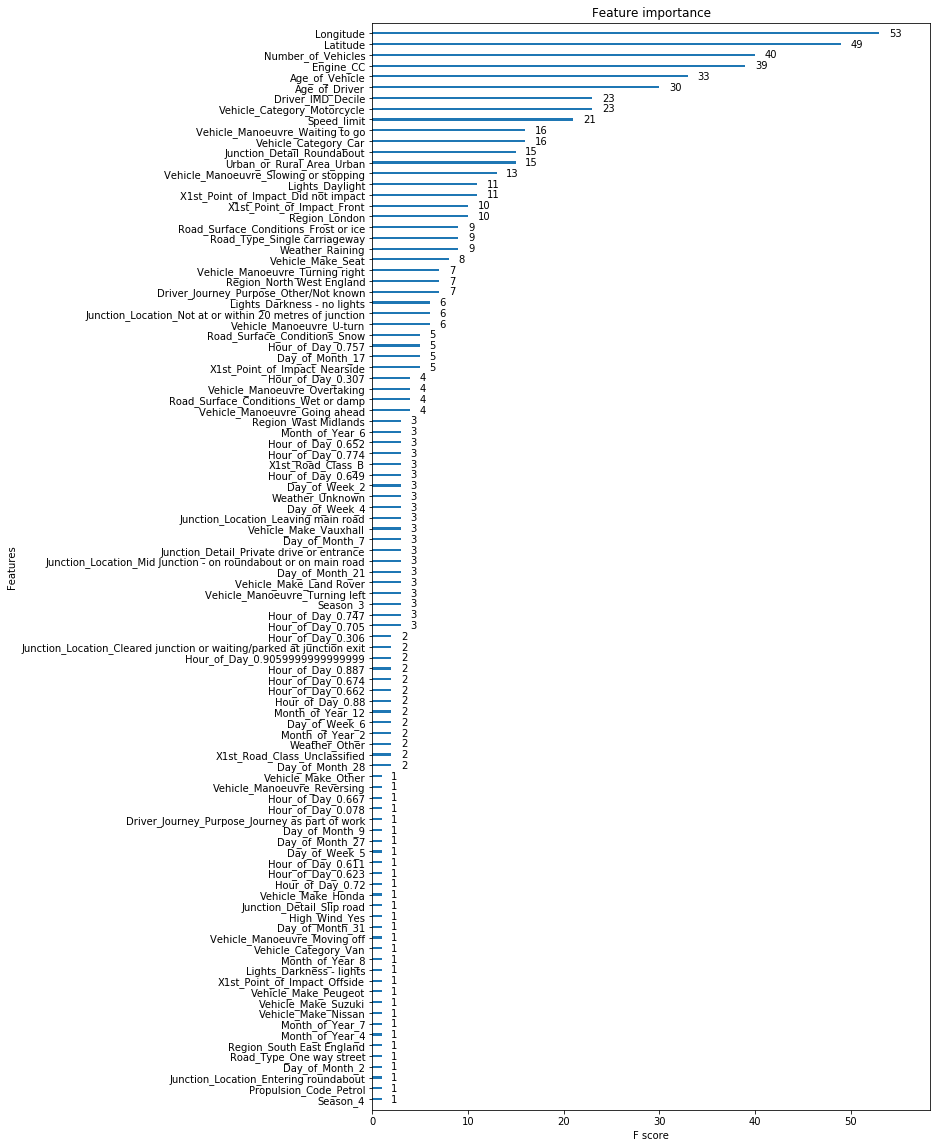

In [24]:
# Features= X_train
# Target=y_train
model = XGBClassifier()
model.fit(X, y)
ax = plot_importance(model)
fig = ax.figure
ax.grid(False)
fig.set_size_inches(10,20)
plt.show()

In [ ]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2

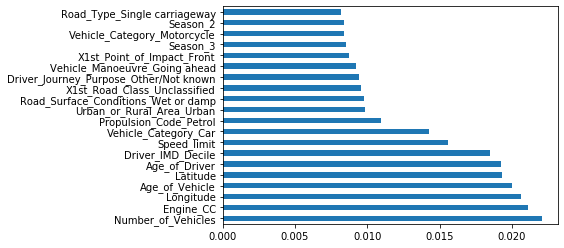

In [22]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [ ]:
.stop

## choosing model

In [25]:
for classifier, cls in zip((XGBClassifier(), LogisticRegression(), RandomForestClassifier(),DecisionTreeClassifier(), AdaBoostClassifier(),GradientBoostingClassifier(), BaggingClassifier(), svm.SVC() ),('xg','logistic regression', 'random forest', 'decision tree', 'adaboost', 'gradient', 'bagging', 'support vector')):

    #y_test1 = np.array([number[0] for number in lb.fit_transform(y_train)])
    #y_train1 = np.array([number[0] for number in lb.fit_transform(y_train)])
    
    print(cls, ":")
    recall = cross_val_score(classifier, X_train, y_train, cv=5, scoring='recall')
    print('Recall', np.mean(recall))
    precision = cross_val_score(classifier, X_train, y_train, cv=5, scoring='precision')
    print('Precision', np.mean(precision))
    f1 = cross_val_score(classifier, X_train, y_train, cv=5, scoring='f1')
    print('F1', np.mean(f1))
    print()

xg :


ValueError: pos_label=1 is not a valid label: array(['Fatal_Serious', 'Slight'], dtype='<U13')

the focus will be on a higher recall score, as safety is the concern.
it appears the SVC model has the highest recall score, but gradient and xgb also come in pretty high and will take less time.

In [ ]:
# pca = PCA()
# pca.fit(X_train, y_train)
# cumsum= np.cumsum(pca.explained_variance_ratio)
# d = np.argmax(cumsum >= 0.80)+1

In [43]:
# looking to keep enough to maintain 80% explained variance
pca = PCA(n_components=60)
principalComponents = pca.fit_transform(X_train)
print(np.sum(pca.explained_variance_ratio_))

0.5553273378234898


In [ ]:
num_feats = 57

In [ ]:
# #baseline model
# pipe_lr = Pipeline([('pca', PCA(n_components=num_feats, random_state=3)),
#          ('clf', LogisticRegression(random_state=3))])

# # Fit the pipelines
# pipe_lr.fit(X_train, y_train)

# print(pipe_lr.score(X_test, y_test))

In [ ]:
# for classifier, pl in zip((XGBClassifier, LogisticRegression, RandomForestClassifier,DecisionTreeClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, svm.SVC),('xgbc','logistic regression', 'random forest', 'decision tree', 'adaboost', 'gradient', 'bagging', 'support vector')):

#     pipe = Pipeline([('pca', PCA(n_components=num_feats)),
#                     ('clf', classifier(random_state=3))])
#                            #print(pl)
#     pipe.fit(X_train, y_train)
#     #print(pipe)
#     print('%s pipeline test accuracy: %.3f' % (pl, pipe.score(X_test, y_test)))                     

In [ ]:
# parameters_for_testing = {
#     'min_child_weight':[0.0001,0.01,1],
#     'learning_rate':[0.0001,0.01,1],
#     'n_estimators':[1,10,100,200],
#     'max_depth':[3,4,5,6]
# }

# xgb_model = XGBClassifier(random_state=3)

# gsearch = GridSearchCV(estimator = xgb_model,
#                         param_grid = parameters_for_testing,
#                         scoring='accuracy',
#                         cv=3)

# gsearch.fit(X_train, y_train)

# print(gsearch.best_params_)
# print('Best score: {:.4}%'.format(gsearch.best_score_ * 100))

## grid search

In [ ]:
# Construct pipeline for support vector grid search

pipe_svm = Pipeline([('pca', PCA(n_components=57)),
            ('clf', svm.SVC(random_state=123))])

# Set grid search params
param_grid_svm = [
  {'clf__C': [0.1, 1, 10]  , 'clf__kernel': ['linear']},
  {'clf__C': [1, 10], 'clf__gamma': [0.001, 0.01], 'clf__kernel': ['rbf']},
 ]

# Construct grid search
gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=param_grid_svm,
            scoring='accuracy',
            cv=3, verbose=2, return_train_score = True)

# Fit using grid search
gs_svm.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_svm.best_score_)

# Best params
print('\nBest params:\n', gs_svm.best_params_)

In [ ]:
# grid search
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


In [ ]:
pipe_kn = Pipeline([('scale', StandardScaler()),
                    ('kn_model', KNeighborsClassifier())])

pipe_tree = Pipeline([('dt_model', DecisionTreeClassifier(random_state=81))])

pipe_bag = Pipeline([('bag_model', BaggingClassifier(DecisionTreeClassifier(random_state=81)))])

pipe_rf = Pipeline([('rf_model', RandomForestClassifier(random_state=81))])

pipe_ada = Pipeline([('ada_model', AdaBoostClassifier(random_state=81))])

pipe_gbt = Pipeline([('gbt_model', GradientBoostingClassifier(random_state=81))])

pipe_xgb = Pipeline([('xgb_model', XGBClassifier(random_state=81))])

In [ ]:
# Fitting all the pipelines with our data

pipelines = [pipe_kn, pipe_tree, pipe_bag, pipe_rf, pipe_ada, pipe_gbt, pipe_xgb]
pipeline_names = ['KNeighbors','Decision Tree', 'Bagged Trees', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost']

for pipe in pipelines:
    print(pipe)
    pipe.fit(X_train, y_train)
    print('---------------------------------------------------')

In [ ]:
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [ ]:
for index, val in enumerate(pipelines):
    print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))

Decision tree

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

predictions = dt_model.predict(X_test)
actuals = y_test

In [ ]:

# Using our function from before, plotting the feature importance levels
plot_feature_importances(dt_model)

In [ ]:
dt_model_train_score = dt_model.score(X_train, y_train)
print("Training Accuracy: {:.4}%".format(dt_model_train_score * 100))

dt_model_test_score = dt_model.score(X_test, y_test)
print("Testing Accuracy: {:.4}%".format(dt_model_test_score * 100))

# dt_cv_score = np.mean(cross_val_score(dt_model, X, y, cv=3))
# print("Cross Val Score: {:.4}%".format(dt_cv_score * 100))

# false_positive_rate, true_positive_rate, thresholds = roc_curve(actuals, predictions)
# roc_auc = auc(false_positive_rate, true_positive_rate)
# print("AUC is : {:.4}%".format(roc_auc * 100))

print("\nClassification Report:")
print(classification_report(actuals, predictions))

print("\nConfusion Matrix: 1=fatal, 0=slight")
pd.crosstab(actuals, predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)


In [ ]:
param_grid_dt = [
    {'dt_model__criterion': ['entropy','gini'],
    'dt_model__max_depth': [3,4,5,6,7,8],
    'dt_model__min_samples_split': [0.01,0.1],
    'dt_model__min_samples_leaf': [0.01,0.1]}
]

# Construct Grid Search
gs_dt = GridSearchCV(estimator=pipe_tree,
                    param_grid=param_grid_dt,
                    scoring='accuracy',
                    cv=4, n_jobs=-1, verbose=1)

# Fit using grid search
gs_dt.fit(X, y)

# Best accuracy and parameters
print('Best accuracy: {:.4}%'.format(gs_dt.best_score_ * 100))
print('Best Params:\n', gs_dt.best_params_)

In [ ]:

dt_gs_model = DecisionTreeClassifier(criterion='gini',
                               max_depth=4,
                               min_samples_leaf=0.01,
                               min_samples_split=0.01)
dt_gs_model.fit(X_train, y_train)

predictions = dt_gs_model.predict(X_test)
actuals = y_test

In [ ]:

dt_gs_model_train_score = dt_gs_model.score(X_train, y_train)
print("Training Accuracy: {:.4}%".format(dt_gs_model_train_score * 100))

dt_gs_model_test_score = dt_gs_model.score(X_test, y_test)
print("Testing Accuracy: {:.4}%".format(dt_gs_model_test_score * 100))

dt_gs_cv_score = np.mean(cross_val_score(dt_gs_model, X, y, cv=3))
print("Cross Val Score: {:.4}%".format(dt_gs_cv_score * 100))

false_positive_rate, true_positive_rate, thresholds = roc_curve(actuals, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("AUC is : {:.4}%".format(roc_auc * 100))

print("\nClassification Report:")

print(classification_report(actuals, predictions))

print("\nConfusion Matrix: 1=Made, 0=Miss")
pd.crosstab(actuals, predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [ ]:
# # pipeline
# pipe_rf = Pipeline([('pca', PCA(n_components=num_feats)),
#             ('clf', svm.SVC(random_state = 3))])

# # grid search params
# param_grid_forest = [ 
#   {'clf__n_estimators': [100],
#    'clf__criterion': ['entropy', 'gini'], 
#    'clf__max_depth': [4, 5, 6],  
#    'clf__min_samples_leaf':[0.001 ,0.005, 0.010],  
#    'clf__min_samples_split':[0.009 ,0.01, 0.011]
#   }
# ]

# # Construct grid search
# gs_rf = GridSearchCV(estimator=pipe_rf,
#             param_grid=param_grid_forest,
#             scoring='accuracy',
#             cv=3, verbose=2,return_train_score = True)

# # Fit using grid search
# gs_rf.fit(X_train, y_train)

# # Best accuracy
# print('Best accuracy: %.3f' % gs_rf.best_score_)

# # Best params
# print('\nBest params:\n', gs_rf.best_params_)

In [ ]:
#gs_rf.cv_results_

In [ ]:
# #ADABOOST
# # Construct pipeline
# pipe_ab = Pipeline([('pca', PCA(n_components=55)),
#             ('clf', AdaBoostClassifier(random_state = 3))])

# #grid search params
# adaboost_param_grid = {
#     'clf__n_estimators': [70, 75, 80],
#     'clf__learning_rate': [1.0, 0.5, 0.1]
# }

# # Construct grid search
# gs_ab = GridSearchCV(estimator=pipe_ab,
#             param_grid=adaboost_param_grid,
#             scoring='accuracy',
#             cv=3, verbose=2, return_train_score = True)

# # Fit grid search
# gs_ab.fit(X_train, y_train)

# # Best accuracy
# print('Best accuracy: %.3f' % gs_ab.best_score_)

# # Best params
# print('\nBest params:\n', gs_ab.best_params_)

In [ ]:
#gs_ab.cv_results_

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [ ]:
#gs_svm.cv_results_

## modeling

## IGNORE BELOW

In [ ]:
# from sklearn.linear_model import SGDClassifier
# sgd_clf = SGDClassifier(random_state=123)
# sgd_clf.fit(X_train, y_train_fatal)

In [ ]:
# from sklearn.model_selection import cross_val_score
# cross_val_score(sgd_clf, X_train, y_train_fatal, cv=3, scoring="accuracy")

In [ ]:
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_train_fatal, y_train_pred)

In [ ]:
# from sklearn.metrics import precision_score, recall_score, f1_score

# print("accuracy score:")
# precision_score(y_train_fatal, y_train_pred)

# print ("recall score:")
# recall_score(y_train_fatal, y_train_pred)

# print("f1 score:")
# f1_score(y_train_fatal, y_train_pred)

In [ ]:
# y_scores = cross_val_predict(sgd_clf, X_train, y_train_fatal, cv=3, method="decision_function")

In [ ]:
# from sklearn.metrics import precision_recall_curve
# precisions, recalls, thresholds = precision_recall_curve(y_train_fatal, y_scores)

In [ ]:
# def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
#     plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
#     plt.plot(thresholds, recalls[:-1], "g--", label="Recall")

In [ ]:
# plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
# plt.show()

In [ ]:
# from sklearn.metrics import roc_curve
# fpr, tpr, thresholds = roc_curve(y_train_fatal, y_scores)

In [ ]:
# def plot_roc_curve(fpr, tpr, label=None):
#     plt.plot(fpr, tpr, linewidth=2, label=label)
#     plt.plot([0,1], [0,1], 'k--')

In [ ]:
# plot_roc_curve(fpr, tpr)

In [ ]:
# from sklearn.metrics import roc_auc_score
# roc_auc_score(y_train_fatal, y_scores)

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# forest_clf = RandomForestClassifier(random_state=42)
# y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_fatal, cv=3, method="predict_proba")

In [ ]:
# y_scores_forest = y_probas_forest[:, 1]
# fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_fatal, y_scores_forest)

In [ ]:
# plt.plot(fpr, tpr, "b:", label='SGD')
# plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
# roc_auc_score(y_train_fatal, y_scores_forest)

In [ ]:
# from sklearn.dummy import DummyClassifier
# clf = DummyClassifier(strategy= 'most_frequent').fit(X_train,y_train)
# y_pred = clf.predict(X_test)

# #Distribution of y test
# print('y actual : \n' +  str(y_test.value_counts()))

# #Distribution of y predicted
# print('y predicted : \n' + str(pd.Series(y_pred).value_counts()))

In [ ]:
# # Model Evaluation metrics 
# from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
# print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
# # print('Precision Score : ' + str(precision_score(y_test,y_pred)))
# # print('Recall Score : ' + str(recall_score(y_test,y_pred)))
# # print('F1 Score : ' + str(f1_score(y_test,y_pred)))

# #Dummy Classifier Confusion matrix
# from sklearn.metrics import confusion_matrix
# print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred)))

In [ ]:
# from sklearn.svm import SVC
# svm_clf = SVC()
# svm_clf.fit(X_train[:300], y_train[:300])
# #svm_clf.predict(X[0])

In [ ]:
# cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring = "accuracy")

In [ ]:
# # Import the three supervised learning models from sklearn
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import GaussianNB


# clf_A = RandomForestClassifier(random_state=random_state)
# clf_B = GaussianNB()
# clf_C = SVC(random_state=random_state)

# # Calculate the number of samples for 1%, 10%, and 100% of the training data
# samples_100 = len(y_train)
# samples_10 = int(len(y_train)/10)
# samples_1 = int(len(y_train)/100)

# # Collect results on the learners
# results = {}
# for clf in [clf_A, clf_B, clf_C]:
#     clf_name = clf.__class__.__name__
#     results[clf_name] = {}
#     for i, samples in enumerate([samples_1, samples_10,   samples_100]):
#         results[clf_name][i] = \
#         y_train_pred(clf, samples, X_train, y_train, X_test, y_test)

# # Run metrics visualization for the three supervised learning models chosen
# vs.evaluate(results, accuracy, fscore)